In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time

now_path        =   '../BRILLOUIN/TDP43/ARS_10_02/'
spectra_filename    =   'ARS_10_02'
VIPA_filename       =   'ARS_10_02_VIPA1.tif'


syg_kwargs          =   {'height': 20, 'distance': 20, 'width': 3.5}
syg_kwargs_VIPA     =   {'distance':100, 'width': 1}
syg_kwargs_brill    =   {'height': 5, 'distance': 30, 'width': 3.}

cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


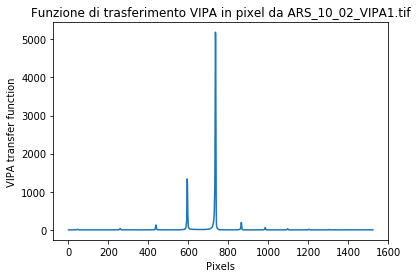

Spettro invisibile
Lo spettro è invisible
Lo spettro ha 7 picchi


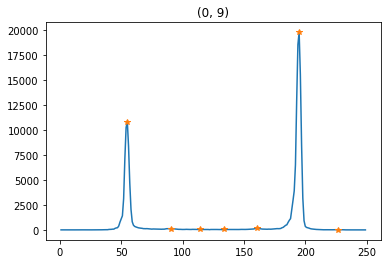

In [2]:
#0) importo dati e inizializzo oggetti
i   =   0
j   =   9
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = False, cut_range = (100, 680))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks[0]], Data.y[Data.peaks[0]], '*')
plt.title(str((i,j)))

check = Data.Check_Spectrum(saturation_width = 13.5)

if      check == 1  : nature    = 'saturo'
elif    check == 2  : nature    = 'brillouin_higher'
elif    check == 3  : nature    = 'invisible'
else:                 nature    = 'bono'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))

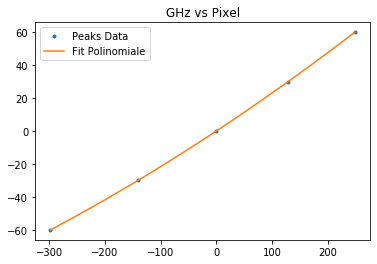

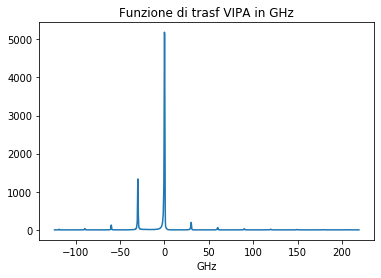



Ho stimato 12 parametri iniziali per il fit che andrai a fare

Co  = 1.000 

Omega  = 7.452 

Gamma  = 0.638 

Delta  = 0.638 

tau  = 10.000 

delta_width  = 0.500 

delta_amplitude  = 1.000 

A  =  nan 

mu  =  nan 

sigma  =  nan 

shift  = 0.000 

offset  = 54.739 

Ho stimato i parametri della gaussiana come A = 5731.71	mu  = -6.22	sigma = 13.92
E li ho aggiunti ai parametri iniziali per il fit. Ora conosco 12 parametri su 12 



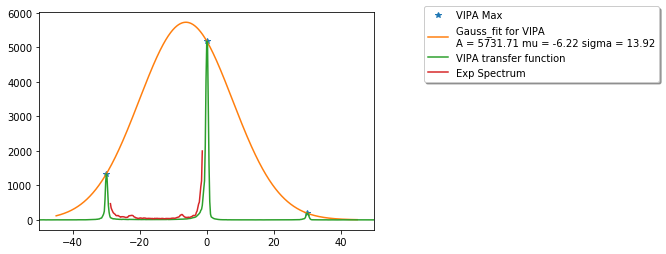

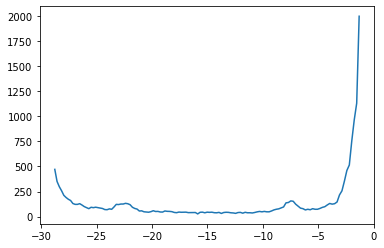

In [3]:
#1) Operazioni di modifica Spettro

Data.How_Many_Peaks_To_VIPA(treshold = 50, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)
Data.Spectrum_Pix2GHz()

if nature == 'brillouin_higher':  

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    Data.Get_Spectrum_4_Peaks_by_Order()

else:           

    Data.Get_Spectrum_4_Peaks_by_Height()

Data.Cut_n_Estimate_Spectrum(estimate = True, verbose = True, distanza = 0.25, columns = cols)
Data.Fit_VIPA_Gaussian(verbose = True, fig = True)
plt.figure()
plt.plot(Data.x_freq, Data.y)

costo = 304727.5762822146
s impiegati a fare il fit  9.074581824 

costo dopo fit = 613.4335439691214
                Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.058729  7.429868  0.151940     0.095718        15.307148   
StdErrs   0.120859  0.024059  0.015639     0.179384       422.017283   
Initials  1.000000  7.561185  0.608234     0.500000         1.000000   

                     A         mu      sigma     shift     offset  
Values    6.301304e+03  -5.599314  12.526879  0.085913   0.751319  
StdErrs   1.463231e+10  36.534111  24.073930  0.024490   0.397152  
Initials  5.731713e+03  -6.221460  13.918754  0.000000  13.057995  
Valore stimato della cost function prima del fit totale con fit markoviano:
613.4335439691214


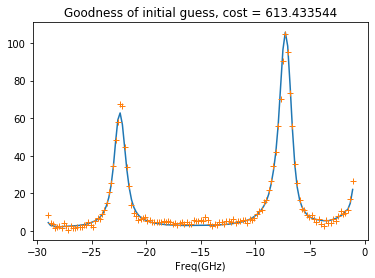

In [4]:
#3) fit markoviano
Data.Get_p0_by_Markov(Data.p0.values[0],treshold = 1000)
print(Data.Markov_Fit_Params)
Data.Take_A_Look_Before_Fitting()

Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5242e+02                                    2.58e+03    
       1              2         2.4807e+02      3.04e+02       1.12e+00       3.84e+02    
       2              4         2.0366e+02      4.44e+01       5.32e-01       1.57e+02    
       3              5         1.8383e+02      1.98e+01       5.28e-01       3.86e+01    
       4              6         1.7536e+02      8.47e+00       1.08e+00       3.67e+01    
       5              7         1.6887e+02      6.48e+00       2.23e+00       7.26e+01    
       6              8         1.6371e+02      5.16e+00       6.91e+00       1.02e+02    
       7              9         1.5853e+02      5.18e+00       3.73e+00       1.41e+02    
       8             10         1.5416e+02      4.37e+00       2.49e+00       3.85e+01    
       9             11         1.5316e+02      1.00e+00       1.85e+00       7.02e+00    
  

1

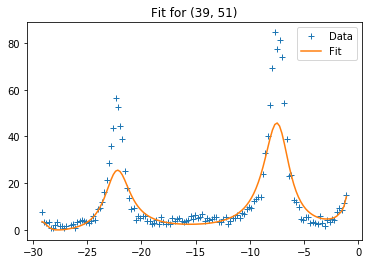

In [5]:
#4) fit totale
percents                    =   (0.2, 0.1, 0.1, 'positive', 'positive', 0.15, 0.15, np.inf, np.inf)
Data.Get_Fit_Bounds(percents, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 200)


In [0]:
Data.Tot_Fit_Params

In [8]:
Data.p0

,Co,Omega,Gamma,Delta,tau,delta_width,delta_amplitude,A,mu,sigma
Values,1.0,7.525954,0.974416,0.5,1.0,3965.502877,-2.085884,-13.301333,0.0,26.439036


In [5]:
Data.Brillouin_HIgher

False

Ho trovato valore dell'altezza per avere 4 picchi: 12.861111
 (array([117, 178, 346, 400], dtype=int64), {'peak_heights': array([1.28888889e+01, 1.00066111e+04, 1.74444444e+02, 2.99277222e+04]), 'prominences': array([8.38888889e+00, 9.97233333e+03, 7.12777778e+01, 2.99263889e+04]), 'left_bases': array([ 34,  34, 277,  34], dtype=int64), 'right_bases': array([137, 277, 355, 507], dtype=int64), 'widths': array([5.082644  , 9.31304439, 7.93207654, 8.62797485]), 'width_heights': array([8.69444444e+00, 5.02044444e+03, 1.38805556e+02, 1.49645278e+04]), 'left_ips': array([115.34313725, 171.01576886, 341.56527094, 394.92022537]), 'right_ips': array([120.42578125, 180.32881325, 349.49734748, 403.54820021])})


 Ho trovato 4 picchi nel tuo spettro sperimentale con le caratteristiche richieste
 Altezza > 12.86 
 Spessore > 5.00 



 Il picco 1 ha: 	 indice = 117 	 x_value (GHz) = -37.19 	 ampiezza(GHz) = 5.08 	 altezza = 12.89 


 Il picco 2 ha: 	 indice = 178 	 x_value (GHz) = -29.66 	 ampiezza(

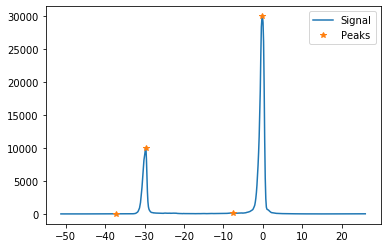

In [18]:
Data.How_Many_Peaks_To(fig = True, verbose=True, i_know_it_is=True)